In [17]:
%pwd  #look at the current work dir
%cd  /eris/u/jschubert/optimism_transformer/
import sys
import pandas as pd
sys.path.append('src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/eris/u/jschubert/optimism_transformer


In [6]:
name = 'debug'
full_df = pd.read_csv('/u/jschubert/learning_bias/llm/agency/data/debug/rw_fit_default.csv')

# drop rows of part_run.max() because they are not complete
#full_df = full_df[full_df['part_run'] != full_df['part_run'].max()]
full_df

,meta_rl_model,agency_type,fitting_model,part_run,nll,bic,beta,alpha_free,alpha_forced,alpha_free_pos,alpha_free_neg,alpha_forced_pos,alpha_forced_neg
0,debug,default,Model_2alpha,0,334.715151,689.168055,0.104774,0.539708,0.906887,NaN,NaN,NaN,NaN
1,debug,default,Model_2alpha,1,332.336645,684.411044,0.351392,0.007248,0.510144,NaN,NaN,NaN,NaN
2,debug,default,Model_2alpha,2,334.623392,688.984537,0.145270,0.185111,0.254287,NaN,NaN,NaN,NaN
3,debug,default,Model_2alpha,3,335.007506,689.752766,0.070936,0.186722,0.634630,NaN,NaN,NaN,NaN
4,debug,default,Model_2alpha,4,332.517527,684.772808,0.557428,0.020219,0.134924,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,debug,default,Model_4alpha,19,335.415211,703.726678,0.013266,NaN,NaN,0.570172,0.321539,0.544728,0.300929
68,debug,default,Model_4alpha,20,333.814703,700.525661,0.275944,NaN,NaN,0.155253,0.103376,0.050521,0.936503
69,debug,default,Model_4alpha,21,335.114608,703.125472,0.122814,NaN,NaN,0.022255,0.037936,0.245343,0.628595
70,debug,default,Model_4alpha,22,333.126254,699.148764,0.542548,NaN,NaN,0.002008,0.777386,0.017780,0.042780


# Comparison 3 models

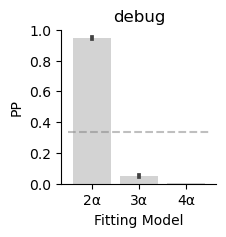

In [8]:
p = full_df[full_df['meta_rl_model'] == name]
pivoted = p.pivot(index='part_run', columns='fitting_model', values='bic')

# calculate PP
bic_diff = pivoted.sub(pivoted.min(axis=1), axis=0)
unnormalized_pp = np.exp(-0.5 * bic_diff)
normalized_pp = unnormalized_pp.div(unnormalized_pp.sum(axis=1), axis=0)

# convert to plotting format
reset = normalized_pp.reset_index()
reset.head()
melt = reset.melt(id_vars='part_run', 
            value_vars=reset.columns[1:],
            var_name='fitting_model',
            value_name='bic')


plt.figure(figsize=(2,2))
plt.ylim(0, 1)

sns.barplot(data=melt, x='fitting_model', y='bic', color='lightgrey')
sns.despine()

# change labels to 2α 3α 4α
labels = ['2α', '3α', '4α']
plt.xticks(np.arange(3), labels)
plt.xlabel('Fitting Model')
plt.ylabel('PP')
plt.title(name)

plt.hlines(y=melt.mean(numeric_only=True)['bic'], xmin=-0.5, xmax=2.5, linestyle='--', alpha=0.5, color='grey')


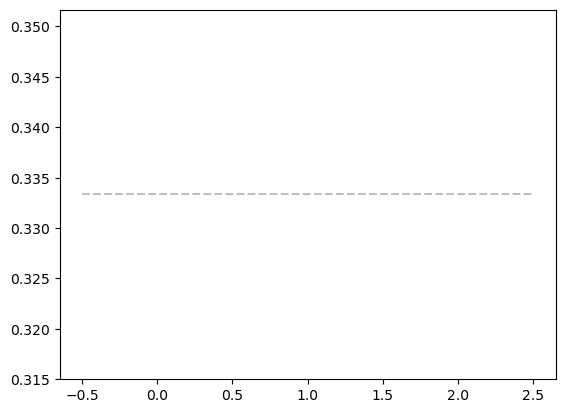

In [10]:

plt.hlines(y=melt.mean(numeric_only=True)['bic'], xmin=-0.5, xmax=2.5, linestyle='--', alpha=0.5, color='grey')


In [11]:
fit = pd.concat([normalized_pp.mean().round(2), normalized_pp.sem().round(3)], axis=1, keys=['mean', 'sem'])

fit.loc['mean', 'mean'] = melt.mean(numeric_only=True)['bic']
fit

,mean,sem
fitting_model,,
Model_2alpha,0.950000,0.005
Model_3alpha,0.050000,0.004
Model_4alpha,0.000000,0.000
mean,0.333333,NaN


# Model 4 Alpha

Text(0.5, 1.0, 'debug - Model 4 alpha')

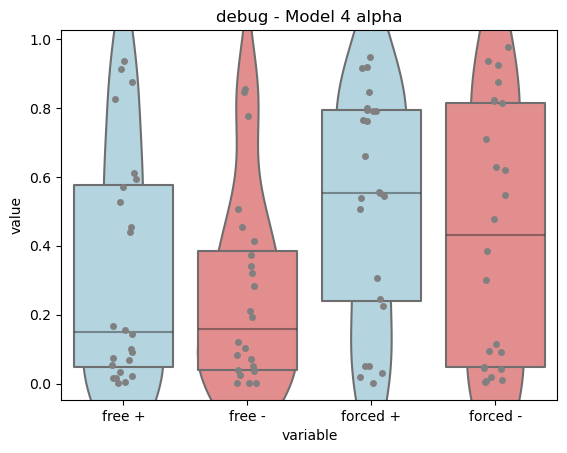

In [12]:
df = full_df[(full_df['meta_rl_model'] == name) & (full_df['fitting_model'] == 'Model_4alpha')]

plot_df = pd.DataFrame({'free +': df.alpha_free_pos, 
                        'free -': df.alpha_free_neg, 
                        'forced +': df.alpha_forced_pos, 
                        'forced -': df.alpha_forced_neg})

plt_df = plot_df.melt()

palette = ['lightblue', 'lightcoral', 'lightblue', 'lightcoral']

sns.violinplot(x="variable", y="value", data=plt_df, palette=palette, inner=None)
sns.stripplot(x="variable", y="value", data=plt_df, jitter=True, color='grey')
sns.boxenplot(x="variable", y="value", data=plt_df, palette=palette, showfliers=False)

plt.title(f'{name} - Model 4 alpha')

In [13]:
plot_df = pd.DataFrame({'beta': df.beta,
                        'free +': df.alpha_free_pos, 
                        'free -': df.alpha_free_neg, 
                        'forced +': df.alpha_forced_pos, 
                        'forced -': df.alpha_forced_neg})
plot_df.mean()


beta        0.302203
free +      0.320731
free -      0.256527
forced +    0.525896
forced -    0.429995
dtype: float64

In [26]:
plot_df.count()

beta        24
free +      24
free -      24
forced +    24
forced -    24
dtype: int64

In [14]:
import scipy.stats as stats

res, pvalue = stats.ttest_rel(plot_df['free +'], plot_df['free -'])
res1, pvalue1 = stats.ttest_rel(plot_df['forced +'], plot_df['forced -'])

print(f'pvalue for post-free difference: {pvalue:.8f}')
print(f'pvalue for post-forced difference: {pvalue1:.4f}')

pvalue for post-free difference: 0.45540096
pvalue for post-forced difference: 0.4032


In [11]:
df.bic.mean()

223.9643783244905

# Model 3 Alpha

Text(0.5, 1.0, 'debug - Model 3 alpha')

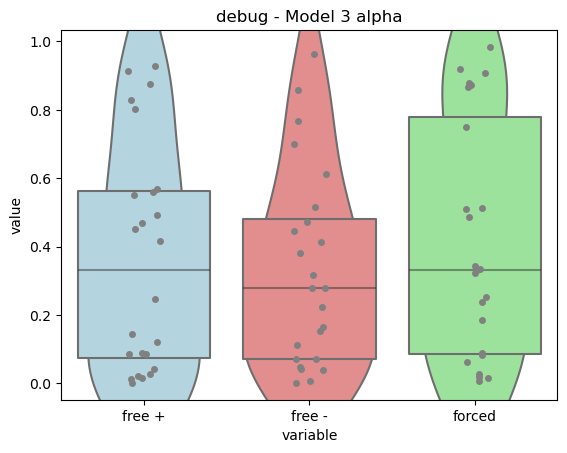

In [15]:
df = full_df[(full_df['meta_rl_model'] == name) & (full_df['fitting_model'] == 'Model_3alpha')]

plot_df = pd.DataFrame({'free +': df.alpha_free_pos, 
                        'free -': df.alpha_free_neg, 
                        'forced': df.alpha_forced})

plt_df = plot_df.melt()

palette = ['lightblue', 'lightcoral', 'lightgreen']

sns.violinplot(x="variable", y="value", data=plt_df, palette=palette, inner=None)
sns.stripplot(x="variable", y="value", data=plt_df, jitter=True, color='grey')
sns.boxenplot(x="variable", y="value", data=plt_df, palette=palette, showfliers=False)

plt.title(f'{name} - Model 3 alpha')

In [13]:
df.nll.mean()

103.073580153388

# Model 2 Alpha

Text(0.5, 1.0, 'debug - Model 2 alpha')

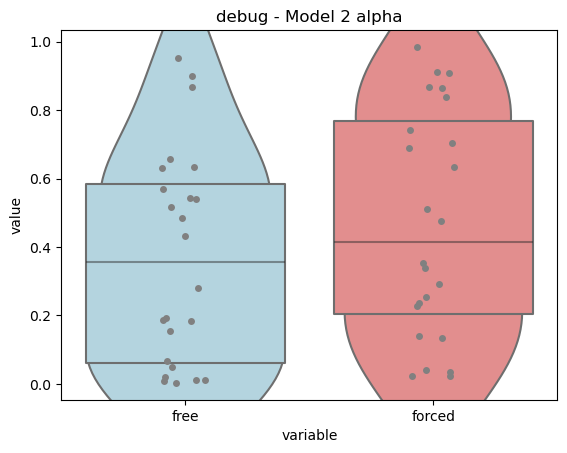

In [16]:
df = full_df[(full_df['meta_rl_model'] == name) & (full_df['fitting_model'] == 'Model_2alpha')]

plot_df = pd.DataFrame({'free': df.alpha_free, 
                        'forced': df.alpha_forced})

plt_df = plot_df.melt()

palette = ['lightblue', 'lightcoral', 'lightgreen']

sns.violinplot(x="variable", y="value", data=plt_df, palette=palette, inner=None)
sns.stripplot(x="variable", y="value", data=plt_df, jitter=True, color='grey')
sns.boxenplot(x="variable", y="value", data=plt_df, palette=palette, showfliers=False)

plt.title(f'{name} - Model 2 alpha')